# Model Training v2 - With Feature Engineering

**Goal:** Train a model to predict `averageRating` using engineered features.

**Input:** `data/movies_wide.csv` (298k movies, 31 features)

**Comparison:** Mucahit's baseline (4 raw features, R² = 0.009) vs our v2 (31 engineered features)

**Sections:**
1. Load Data
2. Train/Test Split
3. Baseline Model (Linear Regression)
4. Model Comparison (Ridge, RandomForest, XGBoost)
5. Evaluation & Results
6. Export Best Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For saving model
import pickle

# Configuration
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")
%matplotlib inline

## 1. Load Data

In [2]:
# Load the feature-engineered dataset
df = pd.read_csv("../data/movies_wide.csv")

print(f"Loaded {len(df):,} movies with {len(df.columns)} columns")
print(f"\nColumns: {df.columns.tolist()}")
display(df.head())

FileNotFoundError: [Errno 2] No such file or directory: '../data/movies_wide.csv'

In [ ]:
# Check for missing values
print("--- Missing Values ---")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values!")

--- Missing Values ---
startYear    22
decade       22
movie_age    22
dtype: int64


In [ ]:
# Drop rows with missing values (22 movies missing startYear)
df = df.dropna(subset=['startYear'])
print(f"Dropped rows with missing values. Remaining: {len(df):,} movies")

Dropped rows with missing values. Remaining: 298,594 movies


## 2. Train/Test Split

In [ ]:
# Define target and features
TARGET = "averageRating"

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train/Test split (70/30 like Mucahit's baseline)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42  # random_state for reproducibility
)

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nFeatures: {X.columns.tolist()}")

Training set: 209,015 samples, 31 features
Test set: 89,579 samples

Features: ['isAdult', 'startYear', 'numVotes', 'genre_count', 'decade', 'movie_age', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult']


## 3. Baseline Model (Linear Regression)

First, let's replicate Mucahit's approach but with our engineered features.

In [ ]:
# Preprocessing: Impute missing values + Scale features
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
    ],
    remainder="drop"
)

# Baseline: Linear Regression (like Mucahit)
baseline_model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

print(f"Features used: {len(numeric_features)}")
print(numeric_features)

Features used: 31
['isAdult', 'startYear', 'numVotes', 'genre_count', 'decade', 'movie_age', 'runtimeMinutes_capped', 'log_numVotes', 'hit', 'Genre_Drama', 'Genre_Comedy', 'Genre_Documentary', 'Genre_Romance', 'Genre_Action', 'Genre_Crime', 'Genre_Thriller', 'Genre_Horror', 'Genre_Adventure', 'Genre_Mystery', 'Genre_Family', 'Genre_Biography', 'Genre_Fantasy', 'Genre_History', 'Genre_Music', 'Genre_Sci-Fi', 'Genre_Musical', 'Genre_War', 'Genre_Animation', 'Genre_Western', 'Genre_Sport', 'Genre_Adult']


In [ ]:
# Train baseline model
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate
print("--- Baseline Model (Linear Regression) ---")
print(f"R² Score: {r2_score(y_test, y_pred_baseline):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_baseline)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_baseline):.4f}")
print(f"\nMucahit's baseline (4 raw features): R² = 0.0088")
print(f"Our baseline (31 engineered features): R² = {r2_score(y_test, y_pred_baseline):.4f}")

--- Baseline Model (Linear Regression) ---
R² Score: 0.2281
RMSE: 1.1863
MAE: 0.9099

Mucahit's baseline (4 raw features): R² = 0.0088
Our baseline (31 engineered features): R² = 0.2281


## 4. Model Comparison

Let's try different algorithms to see which works best.

In [ ]:
# Define models to compare
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
}

# Store results
results = []

In [ ]:
# Train and evaluate each model
for name, regressor in models.items():
    print(f"Training {name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ("preprocess", preprocessor),
        ("regressor", regressor)
    ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "pipeline": pipeline  # Store for later
    })
    
    print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}\n")

Training LinearRegression...
  R²: 0.2281, RMSE: 1.1863, MAE: 0.9099

Training Ridge...
  R²: 0.2281, RMSE: 1.1863, MAE: 0.9099

Training RandomForest...
  R²: 0.3122, RMSE: 1.1198, MAE: 0.8532



## 5. Evaluation & Results

In [ ]:
# Results comparison table
results_df = pd.DataFrame(results).drop(columns=["pipeline"])

# Add Mucahit's baseline for reference
mucahit_baseline = pd.DataFrame([{
    "Model": "Mucahit Baseline (4 features)",
    "R²": 0.0088,
    "RMSE": None,
    "MAE": None
}])

comparison_df = pd.concat([mucahit_baseline, results_df], ignore_index=True)
print("--- Model Comparison ---")
display(comparison_df)

--- Model Comparison ---


/var/folders/n_/r3y8m6z56hx25mb__42q69hw0000gn/T/ipykernel_99565/4285584840.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([mucahit_baseline, results_df], ignore_index=True)


,Model,R²,RMSE,MAE
0,Mucahit Baseline (4 features),0.008800,NaN,NaN
1,LinearRegression,0.228052,1.186329,0.909904
2,Ridge,0.228052,1.186329,0.909904
3,RandomForest,0.312161,1.119835,0.853164


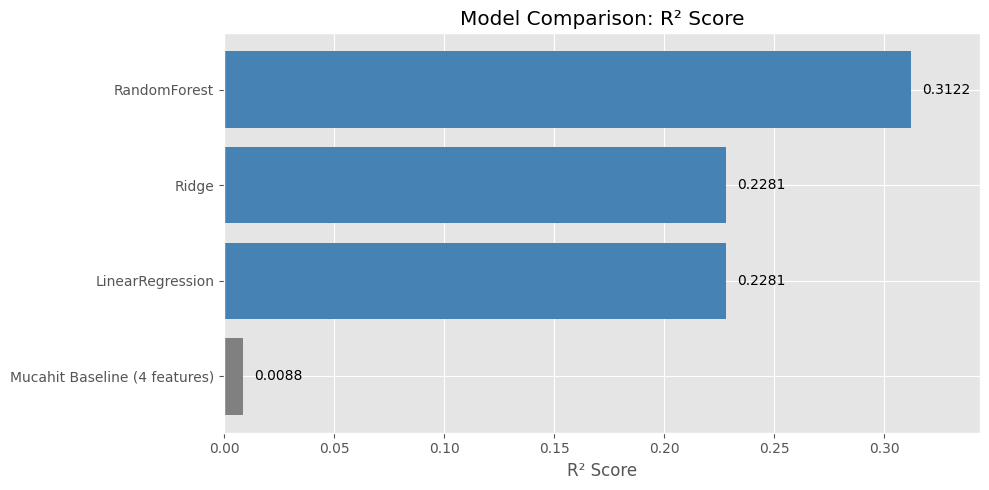

In [ ]:
# Visualize R² scores
plt.figure(figsize=(10, 5))
colors = ['gray'] + ['steelblue'] * len(results)
plt.barh(comparison_df["Model"], comparison_df["R²"], color=colors)
plt.xlabel("R² Score")
plt.title("Model Comparison: R² Score")
plt.xlim(0, max(comparison_df["R²"].max() * 1.1, 0.1))

# Add value labels
for i, v in enumerate(comparison_df["R²"]):
    plt.text(v + 0.005, i, f"{v:.4f}", va="center")

plt.tight_layout()
plt.show()

In [ ]:
# Find best model
best_result = max(results, key=lambda x: x["R²"])
best_model = best_result["pipeline"]

print(f"--- Best Model: {best_result['Model']} ---")
print(f"R²: {best_result['R²']:.4f}")
print(f"RMSE: {best_result['RMSE']:.4f}")
print(f"MAE: {best_result['MAE']:.4f}")

--- Best Model: RandomForest ---
R²: 0.3122
RMSE: 1.1198
MAE: 0.8532


### 5.1 Predicted vs Actual Analysis

Let's visualize how well the best model predicts ratings.

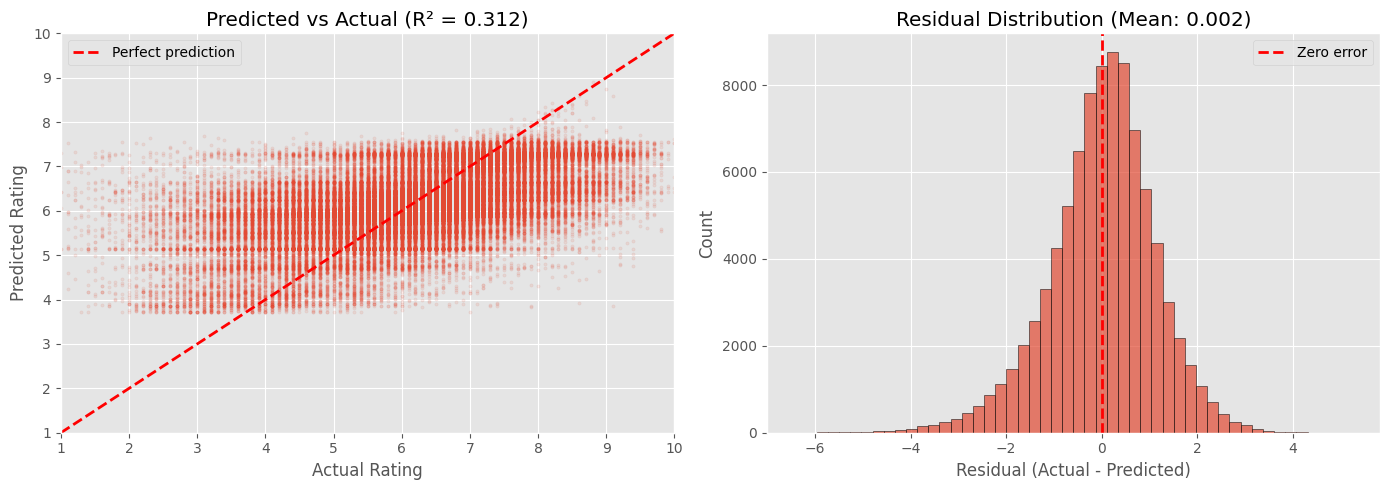

Residual stats: Mean=0.002, Std=1.120


In [ ]:
# Get predictions from best model
y_pred_best = best_model.predict(X_test)

# Predicted vs Actual scatter plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.1, s=5)
axes[0].plot([1, 10], [1, 10], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Rating')
axes[0].set_ylabel('Predicted Rating')
axes[0].set_title(f'Predicted vs Actual (R² = {best_result["R²"]:.3f})')
axes[0].legend()
axes[0].set_xlim(1, 10)
axes[0].set_ylim(1, 10)

# Residual distribution
residuals = y_test - y_pred_best
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Residual Distribution (Mean: {residuals.mean():.3f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Residual stats: Mean={residuals.mean():.3f}, Std={residuals.std():.3f}")

In [ ]:
# Sample predictions table - show 15 random examples
sample_idx = np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 15, replace=False)

sample_df = pd.DataFrame({
    'Actual': y_test.iloc[sample_indices].values,
    'Predicted': y_pred_best[sample_indices],
    'Error': y_test.iloc[sample_indices].values - y_pred_best[sample_indices]
})
sample_df['Abs Error'] = sample_df['Error'].abs()
sample_df = sample_df.round(2)

print("--- Sample Predictions (15 random movies) ---")
display(sample_df)

print(f"\nAverage absolute error in sample: {sample_df['Abs Error'].mean():.2f} rating points")

--- Sample Predictions (15 random movies) ---


,Actual,Predicted,Error,Abs Error
0,4.7,4.61,0.09,0.09
1,4.7,7.29,-2.59,2.59
2,5.3,4.72,0.58,0.58
3,6.8,7.05,-0.25,0.25
4,6.1,6.01,0.09,0.09
5,5.4,5.41,-0.01,0.01
6,6.7,6.90,-0.20,0.20
7,7.0,7.15,-0.15,0.15
8,6.4,6.03,0.37,0.37
9,7.8,6.33,1.47,1.47



Average absolute error in sample: 0.85 rating points


**Interpretation:**

- **Scatter plot**: Points close to the red diagonal = good predictions. The spread shows prediction uncertainty.
- **Residuals**: Centered around 0 = no systematic bias. The model isn't consistently over/under-predicting.
- **Sample table**: Real examples showing prediction accuracy on individual movies.

## 6. Export Best Model

In [ ]:
# Export best model as pickle
model_path = "../models/model_v2.pkl"

# Create models directory if it doesn't exist
import os
os.makedirs("../models", exist_ok=True)

with open(model_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"Model exported to: {model_path}")

# Verify it loads correctly
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

# Quick sanity check
test_pred = loaded_model.predict(X_test[:5])
print(f"\nSanity check - predictions on 5 samples: {test_pred}")

Model exported to: ../models/model_v2.pkl

Sanity check - predictions on 5 samples: [7.37470108 7.20250987 4.70489807 6.73515512 7.26038558]


## Summary

**Key Improvements over Mucahit's Baseline:**
- Feature engineering: 4 raw features → 31 engineered features
- Genre one-hot encoding: captures content type signal
- Log-transformed votes: normalized skewed popularity data
- `hit` feature: binary flag for top 20% popular movies
- Temporal features: `movie_age`, `decade`

**Next Steps:**
- Hyperparameter tuning (GridSearchCV)
- Try XGBoost/LightGBM
- Feature importance analysis
- Integrate with API